<a name ="top"></a>
# Welcome to WWPS (What would Presidents say?)!

We have access to all the US Presidential Speeches from April 30th, 1789 to Sept. 25th, 2019. Presidential speeches are an opportunity for Presidents to set the tone of the country, put forth their agenda, influence policy and sway public opinion. This dataset can give us some good insight into what a President would say about various topics. 

Now we're going to create WWPS i.e. "What would Presidents say?" 
    
We will build a pipeline that, when given a sentence, would spit out the top 3 similar sentences previoulsy uttered by different US presidents.

Source data: https://www.kaggle.com/littleotter/united-states-presidential-speeches

# Introduction

### This is our second pass at the data
The first notebook focused on:
1. Solving the right problem
2. Getting a working model with preliminary results.

### In this notebook we are going to:
1. Spend a little more time exploring the dataset
    - For example we discovered the dataset requires a lot of cleaning.
    - Some was attempted. But for the most part this would require significantly more time
2. Comparing WordEmbedding Model using GLoVe and Sentece Embedding with SentenceBERT
    - We compared to the initial results from GLoVe i.e. did not rerun GLoVe

# TABLE OF CONTENTS

[Go to top](#top)

PART A. [EXPLORING THE DATASET](#step0)  
[Step i: Import Libraries and Load the Data](#stepi)  
[Step ii: Work with a subset](#stepii)  
[Step iii: Characteristics of the dataset](#stepiii)   
[Step iv: Data Cleaning](#stepiv)

PART B. [SENTENCE EMBEDDING](#stepb)  
1. [Define Cosine Similarity Function](#step1)
2. [SentenceBERT](#step2)

PART C. [WORD EMBEDDING](#stepc)  
1. [GLoVe](#step3) 

PART D. RESULTS  
1. [Results](#results)
2. [Limitations](#limitations)
3. [References](#references)

<a name =step0></a>
# PART A - EXPLORING THE DATASET

[Go to top](#top)

<a name =stepi></a>
    
# Step i: Import Libraries and Load the Data

[Go to top](#top)

In [754]:
#import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import numpy as np

from io import StringIO

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

import seaborn as sns
from matplotlib import pyplot as plt

In [755]:
def read_corpus():
    corpus_df = pd.read_csv('corpus.csv')
    return corpus_df

In [756]:
corpus_df = read_corpus()

In [757]:
corpus_df.iloc[:10]

,Unnamed: 0,Party,transcripts
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,John Adams,Federalist,"When it was first perceived, in early times, t..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a..."
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...
8,William Harrison,Whig,Called from a retirement which I had supposed ...
9,John Tyler,Unaffiliated,To the People of the United States Before my a...


In [758]:
corpus_df.rename( columns={"Unnamed: 0" :"President"}, inplace=True )
corpus_df.head()

,President,Party,transcripts
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,John Adams,Federalist,"When it was first perceived, in early times, t..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...


In [759]:
corpus_df.shape

(44, 3)

<a name =stepii></a>
    
# Step ii:  Work with a subset
To speed up processing

[Go to top](#top)

In [760]:
subset_df = corpus_df.iloc[-2:, :]
subset_df

,President,Party,transcripts
42,Barack Obama,Democratic,To Chairman Dean and my great friend Dick Durb...
43,Donald Trump,Republican,"Chief Justice Roberts, President Carter, Presi..."


<a name =stepiii></a>
    
# Step iii:  Characteristics of the dataset
Let's examine the length (no. of characters, words and sentences) in each corpora.

[Go to top](#top)

## Length

### Length by character i.e. letters, spaces and punctuation

In [761]:
len(subset_df.transcripts.iloc[0])

1155148

In [762]:
#Includes letters, spaces and punctuation
len('Hi how are you? Do you?')

23

In [763]:
[len(subset_df.transcripts.iloc[i]) for i in range(subset_df.shape[0])]

[1155148, 475677]

In [764]:
len_char = [len(corpus_df.transcripts.iloc[i]) for i in range(corpus_df.shape[0])]
len_char

[190015,
 88556,
 211059,
 216989,
 297306,
 222338,
 933812,
 389851,
 49669,
 411510,
 620263,
 68280,
 234451,
 385312,
 485593,
 597666,
 569655,
 621306,
 410483,
 17722,
 305870,
 919540,
 836204,
 566308,
 756190,
 709967,
 490304,
 174762,
 452057,
 546456,
 1166892,
 207143,
 105898,
 698750,
 1421446,
 382082,
 240004,
 588246,
 1188847,
 512239,
 768815,
 630362,
 1155148,
 475677]

#### Plots for Length Total Characters

In [765]:
corpus_df["characters"] = len_char
corpus_df.head()

,President,Party,transcripts,characters
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306


<AxesSubplot:>

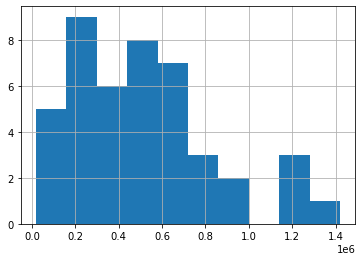

In [766]:
corpus_df['characters'].hist()

<AxesSubplot:ylabel='characters'>

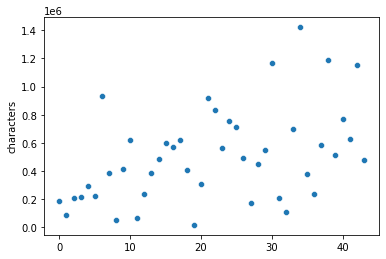

In [767]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="characters")

<a name="words"></a>
### Length by words
Removing punctuation and irrelevant terms where possible as determined in the [Data Cleaning](#stepiv) section below.

In [768]:
len(word_tokenize(subset_df.transcripts.iloc[0]))

232136

In [769]:
#Counts words includes punctation
word_tokenize('Hi how are you? Do you?'), len(word_tokenize('Hi how are you? Do you?'))

(['Hi', 'how', 'are', 'you', '?', 'Do', 'you', '?'], 8)

In [770]:
def clean(doc):
    # Tokenize, clean up input document string
    doc = sub(r'\[[^()]*\]',"", doc)#removes [Applause]["Laughter"]
    #doc = sub("[^\w\s]", "", doc)# removes punctuation
    doc = sub(r'\b[A-Z][A-Z0-9]+\b'," ",doc) #remove ALL CAPS
    
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf"))]

In [771]:
clean('Hi how are Cow ; "" THOMAS JEFF you [Applause]? Do you?'), len(clean('Hi how are Cow THOMAS JEFF you [Applause]? Do you?'))

(['hi', 'how', 'are', 'cow', 'you', 'do', 'you'], 7)

In [772]:
# remove empty tokens
speeches=(subset_df.transcripts.iloc[0])
words = word_tokenize(speeches)
cleaned_speeches = [clean(speech) for speech in words]
cleanup_tokens = [ tok for tok in cleaned_speeches if tok ]

In [773]:
len(cleaned_speeches), len(cleanup_tokens)

(232136, 206788)

In [784]:
length_speeches=[]
def len_speech(df):  
    for i in range(df.shape[0]):
        speeches=(df.transcripts.iloc[i])
        words = word_tokenize(speeches)
        cleaned_speeches = [clean(speech) for speech in words]
        cleanup_tokens = [tok for tok in cleaned_speeches if tok] 
        length_speeches.append(len(cleanup_tokens))
    return length_speeches


In [778]:
#length_speeches_pres = len_speech(subset_df)

In [785]:
length_speeches_pres = len_speech(corpus_df)
length_speeches_pres

[31502,
 14630,
 35823,
 35991,
 49931,
 36522,
 157443,
 64664,
 8461,
 69398,
 104139,
 11350,
 38775,
 63219,
 80553,
 102775,
 94785,
 102702,
 67144,
 2975,
 49331,
 148480,
 138208,
 91657,
 131859,
 115340,
 85367,
 28863,
 73692,
 88822,
 196292,
 36885,
 18045,
 121563,
 249732,
 67768,
 40397,
 101421,
 208007,
 91350,
 136804,
 108260,
 206788,
 84848]

In [786]:
len(length_speeches_pres)

44

#### Plots for Length Words

In [787]:
corpus_df["total_words"] = length_speeches_pres
corpus_df.head()

,President,Party,transcripts,characters,total_words
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931


<AxesSubplot:xlabel='total_words', ylabel='Count'>

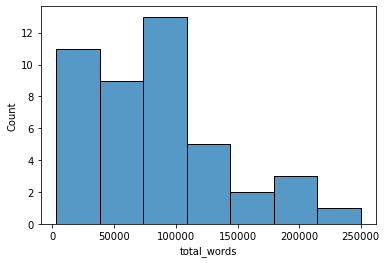

In [788]:
sns.histplot(data=corpus_df, x='total_words')

<AxesSubplot:ylabel='total_words'>

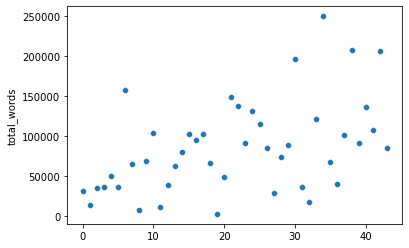

In [789]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="total_words")

## No. of Sentences
1. Normalize text (No. of sentences)
2. No. of unique sentences
3. Most used/repeated sentences

<a name="normalize"></a>
#### 1. Normalize text
Start with a subset again

In [790]:
from re import sub
#gensim simple_preprocess - This lowercases, tokenizes, removes punctuation, de-accents (optional). 
from gensim.utils import simple_preprocess

speeches=(subset_df.transcripts.iloc[0])
sentences=sent_tokenize(speeches)
president =subset_df.President.iloc[0]
president, sentences

('Barack Obama',
 ['To Chairman Dean and my great friend Dick Durbin; and to all my fellow citizens of this great nation; With profound gratitude and great humility, I accept your nomination for the presidency of the United States.',
  'Let me express my thanks to the historic slate of candidates who accompanied me on this journey, and especially the one who traveled the farthest, a champion for working Americans and an inspiration to my daughters and to yours, Hillary Rodham Clinton.',
  'To President Clinton, who last night made the case for change as only he can make it; to Ted Kennedy, who embodies the spirit of service; and to the next Vice President of the United States, Joe Biden, I thank you.',
  'I am grateful to finish this journey with one of the finest statesmen of our time, a man at ease with everyone from world leaders to the conductors on the Amtrak train he still takes home every night.',
  'To the love of my life, our next First Lady, Michelle Obama, and to Sasha and M

In [791]:
len(sentences)

10672

In [792]:
len_sentences=[]
for i in range(corpus_df.shape[0]):
    speeches = (corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    len(sentences)
    len_sentences.append(len(sentences))
len_sentences

[786,
 363,
 938,
 711,
 1385,
 878,
 3700,
 1530,
 206,
 1792,
 2692,
 275,
 1008,
 1464,
 2459,
 3951,
 2532,
 2870,
 1865,
 108,
 1540,
 4202,
 4189,
 2841,
 5519,
 3384,
 2691,
 1189,
 3382,
 3521,
 6457,
 1917,
 809,
 4768,
 12715,
 2802,
 2023,
 5345,
 10300,
 5536,
 6695,
 5939,
 10672,
 6276]

In [793]:
corpus_df["len_sentences"] = len_sentences
corpus_df.head()

,President,Party,transcripts,characters,total_words,len_sentences
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385


<AxesSubplot:xlabel='len_sentences', ylabel='Count'>

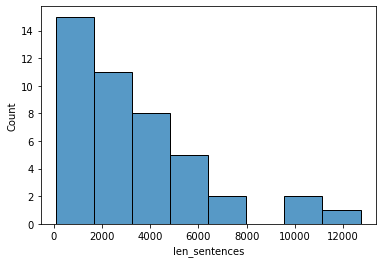

In [794]:
sns.histplot(data=corpus_df, x='len_sentences')

<AxesSubplot:>

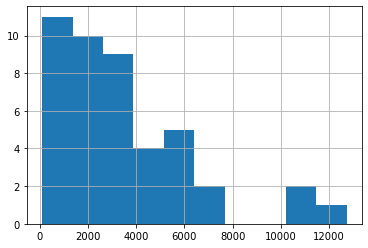

In [795]:
corpus_df['len_sentences'].hist()

<AxesSubplot:ylabel='len_sentences'>

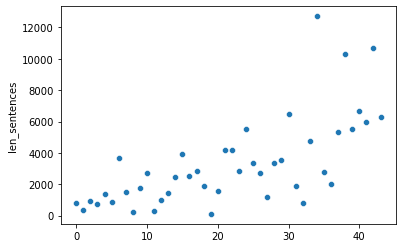

In [796]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="len_sentences")

#### 2. No. of Unique Sentences

Remove duplicate sentences to save computing time later on.

In [797]:
unique_sentences = list(dict.fromkeys(sentences))

In [798]:
len(sentences),len(unique_sentences)

(6276, 5962)

In [799]:
unique_sentences

['Chief Justice Roberts, President Carter, President Clinton, President Bush, President Obama, fellow Americans, and people of the world: thank you.',
 'We, the citizens of America, are now joined in a great national effort to rebuild our country and to restore its promise for all of our people.',
 'Together, we will determine the course of America and the world for years to come.',
 'We will face challenges.',
 'We will confront hardships.',
 'But we will get the job done.',
 'Every four years, we gather on these steps to carry out the orderly and peaceful transfer of power, and we are grateful to President Obama and First Lady Michelle Obama for their gracious aid throughout this transition.',
 'They have been magnificent.',
 "Today's ceremony, however, has very special meaning.",
 'Because today we are not merely transferring power from one Administration to another, or from one party to another – but we are transferring power from Washington, D.C. and giving it back to you, the Ame

In [800]:
len_unique_sentences=[]
for i in range(corpus_df.shape[0]):
    speeches = (corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))
    len(unique_sentences)
    len_unique_sentences.append(len(unique_sentences))
len_unique_sentences

[786,
 361,
 938,
 708,
 1385,
 878,
 3693,
 1528,
 206,
 1772,
 2681,
 275,
 1007,
 1463,
 2446,
 2934,
 2469,
 2798,
 1837,
 108,
 1539,
 4029,
 2522,
 2825,
 5508,
 3292,
 2508,
 1161,
 3382,
 3468,
 6292,
 1916,
 799,
 4630,
 10372,
 2801,
 2023,
 4846,
 9717,
 5008,
 6630,
 5880,
 10386,
 5962]

In [801]:
corpus_df["unique_sentences"] = len_unique_sentences
corpus_df.head()

,President,Party,transcripts,characters,total_words,len_sentences,unique_sentences
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786,786
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363,361
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938,938
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711,708
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385,1385


<AxesSubplot:xlabel='unique_sentences', ylabel='Count'>

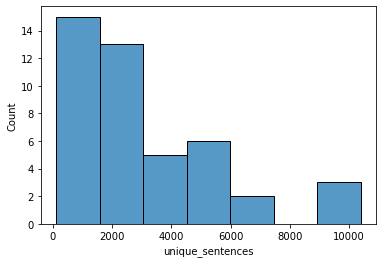

In [802]:
sns.histplot(data=corpus_df, x='unique_sentences')

<AxesSubplot:ylabel='unique_sentences'>

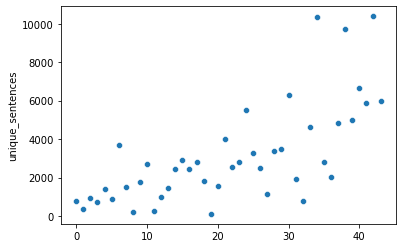

In [803]:
sns.scatterplot(data=corpus_df, x=corpus_df.index, y="unique_sentences")

#### 3. Most used sentences by each president 

This was included as an interesting output. Instead it revealed the data included irrelevant data like crowd response:
- Laughter, Applause
- The names of the Presidents att the end of their speech
- number indices (bullet) points. e.g. 2.
- The President / THE PRESIDENT

In [804]:
import collections

def max_frequency(a_list):
    frequency = collections.Counter(a_list)
    return max(dict(frequency), key=dict(frequency).get), max(dict(frequency).values())


random_list = ['A', 'A', 'B', 'C', 'B', 'D', 'D']
max_frequency(random_list)

('A', 2)

In [805]:
max_frequency(sentences)

('Thank you.', 65)

In [806]:
max_frequency(sentences)[1]

65

In [807]:
most_common_sent=[]
frequency_sent = []
for i in range(corpus_df.shape[0]):
    speeches = (corpus_df.transcripts.iloc[i])
    sentences=sent_tokenize(speeches)
    most_common_sent.append(max_frequency(sentences)[0])
    frequency_sent.append(max_frequency(sentences)[1])
most_common_sent, frequency_sent


(['Fellow Citizens of the Senate and the House of Representatives: Among the vicissitudes incident to life, no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the fourteenth day of the present month.',
  'JOHN ADAMS.',
  'FRIENDS AND FELLOW-CITIZENS, Called upon to undertake the duties of the first executive office of our country, I avail myself of the presence of that portion of my fellow citizens which is here assembled to express my grateful thanks for the favor with which they have been pleased to look toward me, to declare a sincere consciousness that the task is above my talents, and that I approach it with those anxious and awful presentiments which the greatness of the charge and the weakness of my powers so justly inspire.',
  'JAMES MADISON.',
  'I should be destitute of feeling if I was not deeply affected by the strong proof which my fellow citizens have given me of their confidence in call

In [808]:
corpus_df["most_spoken_sentence"] = most_common_sent 
corpus_df["freqency_max_sent"] = frequency_sent
corpus_df

,President,Party,transcripts,characters,total_words,len_sentences,unique_sentences,most_spoken_sentence,freqency_max_sent
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786,786,Fellow Citizens of the Senate and the House of...,1
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363,361,JOHN ADAMS.,3
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938,938,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",1
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711,708,JAMES MADISON.,3
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385,1385,I should be destitute of feeling if I was not ...,1
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",222338,36522,878,878,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",1
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...,933812,157443,3700,3693,"As, then, the period approaches when the appli...",2
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...,389851,64664,1530,1528,M. VAN BUREN.,3
8,William Harrison,Whig,Called from a retirement which I had supposed ...,49669,8461,206,206,Called from a retirement which I had supposed ...,1
9,John Tyler,Unaffiliated,To the People of the United States Before my a...,411510,69398,1792,1772,No.,17


<a name =stepiv></a>
    
# Step iv:  Data Cleaning
Based on findings in the Data Exploration we will remove:

- Laughter, Applause
- The names of the Presidents at the end of their speech
- number indices (bullet) points. e.g. 2.
- The President / THE PRESIDENT

[Go to top](#top)

<a name = "further_cleaning"></a>
### The following will be removed from the Speaches: 

- Square brackets and everything inside them.
    - [ Laughter ], 
    - [ Laughter. ] 
    - [ Applause ] 
    - [ applause ]


- Removing ALL WORDS IN ALL CAPS:
    - The following names: written in ALL CAPS "JOHN ADAMS", "JAMES MADISON" etc.
    - will lose some relevant data like: "FRIENDS AND FELLOW-CITIZENS" by Thomas Jefferson and AND NOW, FRIENDS AND COUNTRYMEN by John Quincy Adams
    

- Will **not** remove:
   - "Second." is valid language usage by Taft and Chester A Arthur
   - Grover Clevland used "2." a lot - in itemizing and references to money. A lot of his figures ended in 20cents! The simple_tokenization by gensim being used removes numbers.
   

### Further Cleaning is required: 
   - Stating the date and location speech was given. Often preceeded by "JOHN ADAMS" -type terms e.g.
        - "Given at Washington, this 23d day of July, A. D. 1813. "
        - "Done at the city of Washington, the 1st day of September, A.D. 1814, and of the Independence of the United States the thirty ninth."
   - There are telegrams within Theodore Rooselvelt's Speech that need to be removed.
   - There may be similar correspondence like this in other copora. Further review required. 
   - I didn't take out proper nouns because of nature of text. But may need to reconsider.

In [809]:
#corpus_df.transcripts.iloc[1] #JOHN ADAMS
#corpus_df.transcripts.iloc[21]

In [810]:
#test regex
pattern = r'\[[^()]*\]'
s = """Issachar is a rawboned [Laughter] donkey lying down among the sheep pens."""
t = re.sub(pattern, '', s)
print(t)

Issachar is a rawboned  donkey lying down among the sheep pens.


The following preprocessing function was used to create the clean function in the [Number of words](#words) section and the preprocessing in the [normalize text](#normalize) section.

In [811]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'\[[^()]*\]', " ", doc) #remove ['Inside Square Brakets']
    doc = sub(r'\b[A-Z][A-Z0-9]+\b'," ",doc) #remove ALL CAPS
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

In [812]:
len(stopwords)

179

In [813]:
test=preprocess(" #letsmove now how YOU! "" ; SEC immediately September 17th 1987 (brown) JOHN ADAM point 2. Cow's, $ $700 'love', come [laughter] http://www.smartkidsclubtt.com is the best!")
test

['letsmove',
 'immediately',
 'september',
 'th',
 'brown',
 'point',
 'cow',
 'love',
 'come',
 'http',
 'www',
 'smartkidsclubtt',
 'com',
 'best']

In [834]:
# Preprocess the documents
corpus_cleaned = [preprocess(sentence) for sentence in unique_sentences] 
corpus_cleaned

[['chief',
  'justice',
  'roberts',
  'president',
  'carter',
  'president',
  'clinton',
  'president',
  'bush',
  'president',
  'obama',
  'fellow',
  'americans',
  'people',
  'world',
  'thank'],
 ['citizens',
  'america',
  'joined',
  'great',
  'national',
  'effort',
  'rebuild',
  'country',
  'restore',
  'promise',
  'people'],
 ['together', 'determine', 'course', 'america', 'world', 'years', 'come'],
 ['face', 'challenges'],
 ['confront', 'hardships'],
 ['get', 'job', 'done'],
 ['every',
  'four',
  'years',
  'gather',
  'steps',
  'carry',
  'orderly',
  'peaceful',
  'transfer',
  'power',
  'grateful',
  'president',
  'obama',
  'first',
  'lady',
  'michelle',
  'obama',
  'gracious',
  'aid',
  'throughout',
  'transition'],
 ['magnificent'],
 ['today', 'ceremony', 'however', 'special', 'meaning'],
 ['today',
  'merely',
  'transferring',
  'power',
  'one',
  'administration',
  'another',
  'one',
  'party',
  'another',
  'transferring',
  'power',
  'washing

In [835]:
len(corpus_cleaned)

5962

In [839]:
transcripts_new=[]
for i in range(corpus_df.shape[0]):
    speeches=(corpus_df.transcripts[i])
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))
    corpus_cleaned = [preprocess(sentence) for sentence in unique_sentences] 
    transcripts_new.append(corpus_cleaned)
corpus_df["transcripts_new"]=transcripts_new

In [840]:
corpus_df

,President,Party,transcripts,characters,total_words,len_sentences,unique_sentences,most_spoken_sentence,freqency_max_sent,transcripts_new
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...,190015,31502,786,786,Fellow Citizens of the Senate and the House of...,1,"[[fellow, citizens, senate, house, representat..."
1,John Adams,Federalist,"When it was first perceived, in early times, t...",88556,14630,363,361,JOHN ADAMS.,3,"[[first, perceived, early, times, middle, cour..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",211059,35823,938,938,"FRIENDS AND FELLOW-CITIZENS, Called upon to un...",1,"[[called, upon, undertake, duties, first, exec..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...,216989,35991,711,708,JAMES MADISON.,3,"[[unwilling, depart, examples, revered, author..."
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...,297306,49931,1385,1385,I should be destitute of feeling if I was not ...,1,"[[destitute, feeling, deeply, affected, strong..."
5,John Quincy Adams,Democratic-Republican,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",222338,36522,878,878,"AND NOW, FRIENDS AND COUNTRYMEN, if the wise a...",1,"[[wise, learned, philosophers, elder, world, f..."
6,Andrew Jackson,Democratic,Fellow Citizens: About to undertake the arduou...,933812,157443,3700,3693,"As, then, the period approaches when the appli...",2,"[[fellow, citizens, undertake, arduous, duties..."
7,Martin Van Buren,Democratic,Fellow Citizens: The practice of all my predec...,389851,64664,1530,1528,M. VAN BUREN.,3,"[[fellow, citizens, practice, predecessors, im..."
8,William Harrison,Whig,Called from a retirement which I had supposed ...,49669,8461,206,206,Called from a retirement which I had supposed ...,1,"[[called, retirement, supposed, continue, resi..."
9,John Tyler,Unaffiliated,To the People of the United States Before my a...,411510,69398,1792,1772,No.,17,"[[people, united, states, arrival, seat, gover..."


<a name =stepb></a>
    
# PART B: SENTENCE EMBEDDING

[Go to top](#top)


<a name =step1></a>
    
# 1. Define Cosine Similarity Function 

[Go to top](#top)

Source: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

In [841]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

<a name =step2></a>
    
# 2. SentenceBERT 

[Go to top](#top)


### Step 1 - Load the pre-trained BERT model. 

There are many other pre-trained models available. You can find the full list of models here. https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md

In [843]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

### Step 2 - Encode sentences from existing corpus. 

We can also display the sentence vectors(just uncomment the code below)

In [ ]:
#cleaned_transcripts = corpus_df["transcripts_new"]
#cleaned/pre-tokenized data was not accepted.
for i in range(corpus_df):
    speeches = corpus_df.transcripts.iloc[i]
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))

#### Let's try for 1 president

In [863]:
speeches = corpus_df.transcripts.iloc[0]
sentences=sent_tokenize(speeches)
unique_sentences = list(dict.fromkeys(sentences))

In [864]:
sentence_embeddings = sbert_model.encode(unique_sentences)

In [865]:
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 768
Sample BERT embedding vector - note includes negative values [-3.19581479e-01  1.13857269e+00  9.57909897e-02  1.03985474e-01
 -7.75964651e-03 -3.86659861e-01  1.01602328e+00 -3.92582193e-02
 -8.11850846e-01 -6.06857300e-01  3.83653373e-01 -1.31526992e-01
  6.13144815e-01  5.03075242e-01 -5.05707040e-02  4.77392703e-01
 -6.93344846e-02 -4.10655528e-01  3.99663746e-01 -6.18104041e-01
 -2.88268000e-01 -6.24450967e-02  2.78923780e-01 -1.14059024e-01
  7.19376147e-01  3.57546061e-01 -1.78535223e-01 -9.04547572e-01
 -1.17598259e+00  5.00557385e-02 -4.35568959e-01 -1.16655938e-01
 -4.29177523e-01 -2.90248334e-01  2.16691300e-01  7.50116765e-01
 -2.11278126e-01 -5.86680293e-01 -1.82806611e-01 -3.76324296e-01
  1.50630087e-01 -6.71070039e-01  2.92798489e-01 -5.71430564e-01
 -8.04362297e-01 -3.98150906e-02  1.16612124e+00  1.24994135e+00
  7.77778804e-01 -5.17707705e-01  1.04991630e-01 -2.75748968e-01
  9.51119423e-01 -5.13205767e-01 -3.70961800e-02 -5.

### Step 3 - Define a test query and encode it as well

In [866]:
query = "I believe I our children are our future."
query_vec = sbert_model.encode([query])[0]

### Step 4 - Compute the cosine similarity using scipy. 

We will retrieve the similarity values between the sentences and our test query:

In [879]:
sim_dict={}
for sent in unique_sentences:
    sim = cosine(query_vec, sbert_model.encode([sent])[0])
    sim_dict[sent]=sim

In [880]:
max_key = max(sim_dict, key=sim_dict.get)
max_value = max(sim_dict.values())
max_key, max_value

('There is a pleasing prospect that the institution will, at no remote day, realize the expectation which was originally formed of its utility.',
 0.72843677)

### Step 5 - Let's do it for ALL Presidents. 

In [ ]:
top_matches = pd.DataFrame()
similar_dict = {}

#For each president:
for i in range(corpus_df.shape[0]):
    speeches = corpus_df.transcripts.iloc[i]
    sentences=sent_tokenize(speeches)
    unique_sentences = list(dict.fromkeys(sentences))
    sentence_embeddings = sbert_model.encode(unique_sentences)
    sim_dict={}
    for sent in unique_sentences:
        sim = cosine(query_vec, sbert_model.encode([sent])[0])
        sim_dict[sent]=sim
    max_key = max(sim_dict, key=sim_dict.get)
    max_value = max(sim_dict.values())
    president = corpus_df.President.iloc[i]
    similar_dict = {'President': president, 'Matching Sentence': max_key, 'Cosine Similarity': max_value}
    top_matches = top_matches.append(similar_dict, ignore_index = True)

top=top_matches.sort_values(by=['Cosine Similarity'], ascending=False)
                
                    
                    

In [ ]:
top[5] 

<a name =stepc></a>
    
# PART C: WORD EMBEDDING

[Go to top](#top)


<a name =step3></a>
    
# 1. GLoVe

[Go to top](#top)

### Step 1: Feature Engineering

In [37]:
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-50")  

In [38]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

  
similarity_index = WordEmbeddingSimilarityIndex(glove)

# Build the term dictionary, TF-idf model
dictionary = Dictionary(corpus+[query])
tfidf = TfidfModel(dictionary=dictionary)


# Create the term similarity matrix.  
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)

### Step 2: Soft Cosine Similarity 

[Go to top](#top)

In [40]:
import numpy as np
# Compute Soft Cosine Measure between the query and the documents.
# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
query_tf = tfidf[dictionary.doc2bow(query)]

index = SoftCosineSimilarity(
            tfidf[[dictionary.doc2bow(sentence) for sentence in corpus]],
            similarity_matrix)

doc_similarity_scores = index[query_tf]

# Output the sorted similarity scores and documents
sorted_indexes = np.argsort(doc_similarity_scores)[::-1] #[::-1] Start at the end, end when it ends, end when nothing's left and walk backwards by 1. 
idx = sorted_indexes[0]
print(f'{idx} \t {doc_similarity_scores[idx]:0.3f} \t {sentences[idx]}')

6 	 0.804 	 In tendering this homage to the Great Author of every public and private good, I assure myself that it expresses your sentiments not less than my own; nor those of my fellow citizens at large, less than either.


### Step 3: Apply to entire Dataframe 

[Go to top](#top)

#### Trial #1 - Used existing phrase in corpora

In [97]:
#terms not loop dependent
query = preprocess(query_string)
similarity_index = WordEmbeddingSimilarityIndex(glove)
top_matches = pd.DataFrame()
for i in range(0,corpus_df.shape[0]):
    speeches=(corpus_df.transcripts[i])
    sentences=sent_tokenize(speeches)
    president =corpus_df.President[i]
    # STEP 2 -TEXT NORMALIZATION
    # Preprocess the documents, including the query string
    corpus = [preprocess(sentence) for sentence in sentences] 
    # STEP 3 - FEATURE ENGINEERING
    # Build the term dictionary, TF-idf model
    dictionary = Dictionary(corpus+[query])
    tfidf = TfidfModel(dictionary=dictionary)
    # Create the term similarity matrix.  
    similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)
    # STEP 4 - SOFT COSINE SIMILARITY
    # Compute Soft Cosine Measure between the query and the documents.
    query_tf = tfidf[dictionary.doc2bow(query)]

    index = SoftCosineSimilarity(
                tfidf[[dictionary.doc2bow(sentence) for sentence in corpus]],
                similarity_matrix)
    doc_similarity_scores = index[query_tf]
    # Output the sorted similarity scores and documents
    sorted_indexes = np.argsort(doc_similarity_scores)
    ranked=sorted_indexes[::-1]
    # runtime warning with index[0] only
    idx = ranked[0]
    # The most relevant sentence from each president
    df = {'President': president, 'Matching Sentence': sentences[idx], 'Index': idx, 'Similarity Score': (doc_similarity_scores[idx])}
    top_matches = top_matches.append(df, ignore_index = True)
    top=top_matches.sort_values(by=['Similarity Score'], ascending=False)

top.head(3)

/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: divide by zero encountered in true_divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))


,President,Matching Sentence,Index,Similarity Score
0,George Washington,In tendering this homage to the Great Author o...,6.0,0.803656
1,John Adams,"Irritated by no literary altercation, animated...",11.0,0.541808
2,Thomas Jefferson,Long absent on duties which the history of a w...,929.0,0.582807
3,James Madison,To meet the extended and diversified warfare a...,526.0,0.559601
4,James Monroe,Under these impressions I invite your attentio...,1307.0,0.532250
5,John Quincy Adams,The next of these cardinal measures of policy ...,812.0,0.608466
6,Andrew Jackson,The beneficent Author of All Good has granted ...,477.0,0.519133
7,Martin Van Buren,The Constitution devised by our forefathers as...,691.0,0.559491
8,William Harrison,I wish for the support of no member of that bo...,203.0,0.471840
9,John Tyler,It will not escape the observation of Congress...,1218.0,0.506621


In [133]:
top=top_matches.sort_values(by=['Similarity Score'], ascending=False)
top.head(3)


,President,Matching Sentence,Index,Similarity Score
0,George Washington,In tendering this homage to the Great Author o...,6.0,0.803656
11,Zachary Taylor,With the strict observance of this rule and th...,216.0,0.649095
42,Barack Obama,"In this effort, we draw inspiration from our f...",5190.0,0.625251


#### Trial #2 - Used short phrase

In [205]:
#terms not loop dependent
query = preprocess('I believe I can fly.')
similarity_index = WordEmbeddingSimilarityIndex(glove)
top_matches = pd.DataFrame()
for i in range(0,corpus_df.shape[0]):
    speeches=(corpus_df.transcripts[i])
    sentences=sent_tokenize(speeches)
    president =corpus_df.President[i]
    # STEP 2 -TEXT NORMALIZATION
    # Preprocess the documents, including the query string
    corpus = [preprocess(sentence) for sentence in sentences] 
    # STEP 3 - FEATURE ENGINEERING
    # Build the term dictionary, TF-idf model
    dictionary = Dictionary(corpus+[query])
    tfidf = TfidfModel(dictionary=dictionary)
    # Create the term similarity matrix.  
    similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)
    # STEP 4 - SOFT COSINE SIMILARITY
    # Compute Soft Cosine Measure between the query and the documents.
    query_tf = tfidf[dictionary.doc2bow(query)]

    index = SoftCosineSimilarity(
                tfidf[[dictionary.doc2bow(sentence) for sentence in corpus]],
                similarity_matrix)
    doc_similarity_scores = index[query_tf]
    # Output the sorted similarity scores and documents
    sorted_indexes = np.argsort(doc_similarity_scores)
    ranked=sorted_indexes[::-1]
    # runtime warning with index[0] only
    idx = ranked[0]
    # The most relevant sentence from each president
    df = {'President': president, 'Matching Sentence': sentences[idx], 'Index': idx, 'Similarity Score': (doc_similarity_scores[idx])}
    top_matches = top_matches.append(df, ignore_index = True)
    top=top_matches.sort_values(by=['Similarity Score'], ascending=False)

top.head(3)

/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: divide by zero encountered in true_divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))


,President,Matching Sentence,Index,Similarity Score
19,James A. Garfield,Fellow Citizens: We stand to-day upon an emine...,0.0,1.0
8,William Harrison,The outline of principles to govern and measur...,5.0,1.0
32,Dwight D. Eisenhower,I would be prepared to submit to the Congress ...,387.0,1.0


In [210]:
top.head(10)

,President,Matching Sentence,Index,Similarity Score
19,James A. Garfield,Fellow Citizens: We stand to-day upon an emine...,0.0,1.000000
8,William Harrison,The outline of principles to govern and measur...,5.0,1.000000
32,Dwight D. Eisenhower,I would be prepared to submit to the Congress ...,387.0,1.000000
3,James Madison,Having forborne to declare war until to other ...,547.0,1.000000
11,Zachary Taylor,We could in no event be indifferent to their p...,129.0,1.000000
9,John Tyler,This union in sentiment and feeling can only b...,1077.0,1.000000
1,John Adams,"I have therefore thought fit to recommend, and...",172.0,0.973850
0,George Washington,But you will perceive from the information con...,36.0,0.972275
6,Andrew Jackson,But if from the original delay in asking for a...,2727.0,0.951481
12,Millard Fillmore,These papers will acquaint you with the ground...,440.0,0.943419


#### Trial 3 a - Added stop words and repeated short phrase query
#### Trial 3 b - Added stop words and more descriptive query 

In [211]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# From: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
def preprocess(doc):
    # Tokenize, clean up input document string
    doc = sub(r'<img[^<>]+(>|$)', " image_token ", doc)
    doc = sub(r'<[^<>]+(>|$)', " ", doc)
    #doc = sub(r'\[img_assist[^]]*?\]', " ", doc)
    doc = sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " url_token ", doc)
    return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf")) if token not in stopwords]

In [218]:
#terms not loop dependent
query = preprocess('I believe that the young people in America are our future.')
similarity_index = WordEmbeddingSimilarityIndex(glove)
top_matches = pd.DataFrame()
for i in range(0,corpus_df.shape[0]): #
    speeches=(corpus_df.transcripts[i])
    sentences=sent_tokenize(speeches)
    president =corpus_df.President[i]
    # STEP 2 -TEXT NORMALIZATION
    # Preprocess the documents, including the query string
    corpus = [preprocess(sentence) for sentence in sentences] 
    # STEP 3 - FEATURE ENGINEERING
    # Build the term dictionary, TF-idf model
    dictionary = Dictionary(corpus+[query])
    tfidf = TfidfModel(dictionary=dictionary)
    # Create the term similarity matrix.  
    similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary, tfidf)
    # STEP 4 - SOFT COSINE SIMILARITY
    # Compute Soft Cosine Measure between the query and the documents.
    query_tf = tfidf[dictionary.doc2bow(query)]

    index = SoftCosineSimilarity(
                tfidf[[dictionary.doc2bow(sentence) for sentence in corpus]],
                similarity_matrix)
    doc_similarity_scores = index[query_tf]
    # Output the sorted similarity scores and documents
    sorted_indexes = np.argsort(doc_similarity_scores)
    ranked=sorted_indexes[::-1]
    # runtime warning with index[0] only
    idx = ranked[0]
    # The most relevant sentence from each president
    df = {'President': president, 'Matching Sentence': sentences[idx], 'Index': idx, 'Similarity Score': (doc_similarity_scores[idx])}
    top_matches = top_matches.append(df, ignore_index = True)
    top=top_matches.sort_values(by=['Similarity Score'], ascending=False)

top.head(3)

/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: divide by zero encountered in true_divide
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))
/Users/sarabernard/opt/anaconda3/lib/python3.9/site-packages/gensim/similarities/termsim.py:358: RuntimeWarning: invalid value encountered in multiply
  Y = np.multiply(Y, 1 / np.sqrt(Y_norm))


,President,Matching Sentence,Index,Similarity Score
1,John Adams,On this subject it might become me better to b...,35.0,1.000000
42,Barack Obama,In order to save our children from a future of...,769.0,0.999880
34,Lyndon B. Johnson,It does say the only limit to a man's hope for...,2383.0,0.982136


In [227]:
#length of top 3
len(top.iloc[0][0]), len(top.iloc[0][1]), len(top.iloc[1][0]), len(top.iloc[1][1]), len(top.iloc[2][0]), len(top.iloc[2][1])

(10, 4345, 12, 127, 17, 119)

<a name =results></a>
    
# PART D - RESULTS

## What would a President say?

[Go to top](#top)

### Result using existing phrase in corpora as query.
- The top matching sentence was the same sentence the excerpt came from. 
- This proves that the algorithm works lexically.

In [202]:
print('Instead of saying: "',query_string,'" ...')

for i in range(0,3):
    print(str('\n' + 'President ' + top.iloc[i][0] + ' would say ' + '"' + top.iloc[i][1] + '"' + '\t' +'Soft Cosine Similarity'), top.iloc[i][3])

Instead of saying: " In tendering this homage to the Great Author of every public and private good " ...

President George Washington would say "In tendering this homage to the Great Author of every public and private good, I assure myself that it expresses your sentiments not less than my own; nor those of my fellow citizens at large, less than either."	Soft Cosine Similarity 0.8036555

President Zachary Taylor would say "With the strict observance of this rule and the other injunctions of the Constitution, with a sedulous inculcation of that respect and love for the Union of the States which our fathers cherished and enjoined upon their children, and with the aid of that overruling Providence which has so long and so kindly guarded our liberties and institutions, we may reasonably expect to transmit them, with their innumerable blessings, to the remotest posterity."	Soft Cosine Similarity 0.6490951

President Barack Obama would say "In this effort, we draw inspiration from our fellow

### Result using short phrase - "I believe I can fly"
- The algorithm returned at least 6 x 100% matching sentences that upon review did not even make sense. 
- Way forward: Add more stop words
- Note: The quality of the input from the user affects the ability to detect semantics.

In [207]:
print('Instead of saying: "I believe I can fly" ...')

for i in range(0,3):
    print(str('\n' + 'President ' + top.iloc[i][0] + ' would say ' + '"' + top.iloc[i][1] + '"' + '\t' +'Soft Cosine Similarity'), top.iloc[i][3])

Instead of saying: "I believe I can fly" ...

President James A. Garfield would say "Fellow Citizens: We stand to-day upon an eminence which overlooks a hundred years of national life- a century crowded with perils, but crowned with the triumphs of liberty and law."	Soft Cosine Similarity 1.0

President William Harrison would say "The outline of principles to govern and measures to be adopted by an Administration not yet begun will soon be exchanged for immutable history, and I shall stand either exonerated by my countrymen or classed with the mass of those who promised that they might deceive and flattered with the intention to betray."	Soft Cosine Similarity 1.0

President Dwight D. Eisenhower would say "I would be prepared to submit to the Congress of the United States, and with every expectation of approval, any such plan that would: First, encourage world wide investigation into the most effective peacetime uses of fissionable material, and with the certainty that they had all the

In [208]:
#top.head(10)

,President,Matching Sentence,Index,Similarity Score
19,James A. Garfield,Fellow Citizens: We stand to-day upon an emine...,0.0,1.000000
8,William Harrison,The outline of principles to govern and measur...,5.0,1.000000
32,Dwight D. Eisenhower,I would be prepared to submit to the Congress ...,387.0,1.000000
3,James Madison,Having forborne to declare war until to other ...,547.0,1.000000
11,Zachary Taylor,We could in no event be indifferent to their p...,129.0,1.000000
9,John Tyler,This union in sentiment and feeling can only b...,1077.0,1.000000
1,John Adams,"I have therefore thought fit to recommend, and...",172.0,0.973850
0,George Washington,But you will perceive from the information con...,36.0,0.972275
6,Andrew Jackson,But if from the original delay in asking for a...,2727.0,0.951481
12,Millard Fillmore,These papers will acquaint you with the ground...,440.0,0.943419


### Result using stop words and "I believe I can fly"
- The stop words *may* have improved the semantics *but* as an idiom was used it is difficult to tell if stop words have improved the results.
- Still very high level of matching in spite of semantics not being clear.
- I only performed the trial on a small subset of corpora from 4 presidents
- The quality of query impacts results so we tried to improve the query in Trial 3b.

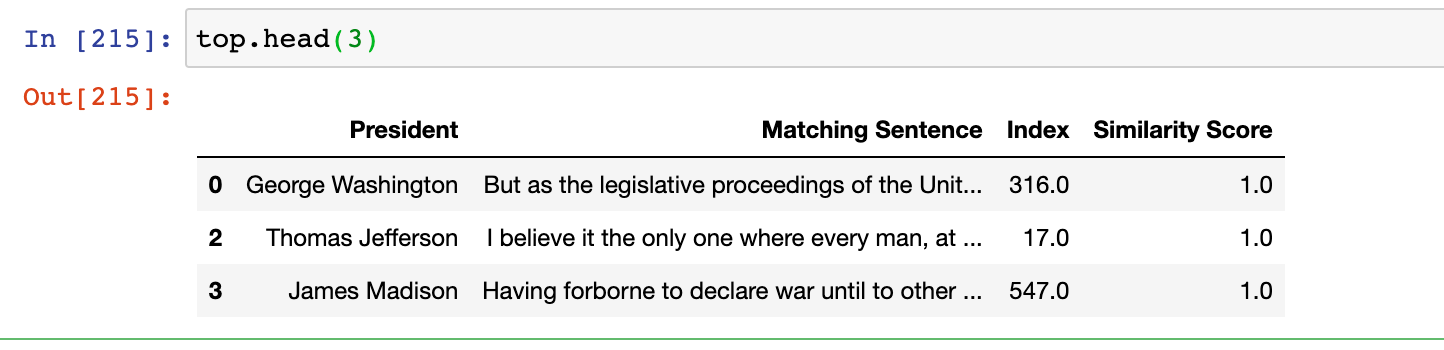

### Result using "I believe that young people are our future"
- The number 1 match was by John Adams, the 2nd President of the United States.
- His sentence was matching sentence had 4345 words compared to ~120 words for the next top 2 presidents; 44th and 36th respectively. This may have been due to typos, an anomoly, perhaps he is known for being wordy or neing wordy was normal back in those day.
- For the more readable sentences at only 120words, by the 2nd and 3rd ranked it is easier to see why they matched well.
- Way forward: Inspect the data to determine if:
    - length of sentences trend with time.
    - length of sentences favour/don't favour being selected in the top 3. 
    - the performance of the algorithm is independent of era of corpus 
- Note: The quality of the input from the user affects the ability to detect semantics.
    - Consider criteria for query. 
    - for e.g at least 2 verbs, 2 nouns, 2 adjectives/adverbs.

In [226]:
print('Instead of saying: "I believe that young people are our future" ...')

for i in range(0,3):
    print(str('\n' + 'President ' + top.iloc[i][0] + ' would say ' + '"' + top.iloc[i][1] + '"' + '\t' +'Soft Cosine Similarity'), top.iloc[i][3])

Instead of saying: "I believe that young people are our future" ...

President John Adams would say "On this subject it might become me better to be silent or to speak with diffidence; but as something may be expected, the occasion, I hope, will be admitted as an apology if I venture to say that if a preference, upon principle, of a free republican government, formed upon long and serious reflection, after a diligent and impartial inquiry after truth; if an attachment to the Constitution of the United States, and a conscientious determination to support it until it shall be altered by the judgments and wishes of the people, expressed in the mode prescribed in it; if a respectful attention to the constitutions of the individual States and a constant caution and delicacy toward the State governments; if an equal and impartial regard to the rights, interest, honor, and happiness of all the States in the Union, without preference or regard to a northern or southern, an eastern or western, 

<a name =limitations></a>
    
# Limitations & Observations

[Go to top](#top)

### Updated Observations:
1. As observed in the Data Exploration section, Presidents' speeches are on average longer today that they were decades ago. So the sentence from the inaugural address by John Adam's is an outlier, having many run-on sentences.
2. Specific areas for preprocessing improvements have been identified including:
    - Removing telegrams and other alternative transcripts and correspondence, introductory and explanatory notes, the president's name and audience response etc as outlined [here](#further_cleaning) 
    In some cases this work is significant.
3. In the time alotted I was able to limit the corpora analysed by the SentenceBERT model to Unique Sentences i.e. with no duplicates (as sometimes President's/people say somethine more than once.)
4. The corpus was not prepared identically both the GLoVe and SentenceBERT.
5. SentenceBERT did not accept pre-tokenized words. 
6. 
   

### Initial Observations

1. I used GloVe, an unsupervised learning algorithm, "glove-wiki-gigaword-50". 
    - There is a newer release and different versions of GloVe based on from different sources (corpus)
    - Perhaps there is a range of corpora better suited to presidential speeches, which are more formally worded.
2. The data dates back to 1789 as such, how language is used has changed. This may impact semantic-consistency across the corpora. 
    - And the results may be biased toward corpora from more modern time periods.
    - Or the results may be biased to longer corpora
3. Preprocessing should be reviewed so Regex and Tokenizaton can be optimized. 
    - Increasing stop words may have helped the performance (ability to detect meaning)
4. This type of semantic search is limited by the quality of the user input. 
    - The more meaning conveyed in the query, the better the model can perform.
5. Consider comparing the performance against Okapi BM25 Ranking or similar model that is tailored to Information Retrieval.
6. Optimize code:
    - I get a runtime warning with index[0] only for the sorted indices of similarity.
7. Improve how I get the data from the user. There are no checks or error messages.
8. I need to investigate how to prove the validity/performance of Text Similarity Models.

<a name =references></a>
    
# References

[Go to top](#top)

1. Text Analytics with Python A practical real-world approach to gaining actional insights from your data - Sarkar, Dipanjan
2. https://towardsdatascience.com/how-to-rank-text-content-by-semantic-similarity-4d2419a84c32
3. GloVe https://nlp.stanford.edu/projects/glove/
4. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
